In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import dummy
from sklearn import linear_model
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure  






/Users/blazingsun88/miniconda3/envs/ml/lib/python3.14/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
# Load the CSV file for the training dataset
data_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(data_train)

df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Check if there are any missing values in the DataFrame
has_missing = data_train.isnull().values.any()
print("Are there any missing values?", has_missing)

#df_train.isna().sum()

# missing_summary = pd.DataFrame({
#     'missing_count': df_train.isnull().sum(),
#     'missing_percentage': df_train.isnull().mean() * 100
# })
# print(missing_summary)

# Only show columns with missing values
df_train.isnull().sum()[df_train.isnull().sum() > 0]


Are there any missing values? True


LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [5]:
df_train = df_train.drop('Id', axis=1)
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### Removing non meaningful Nas

From these missing columns, NaN has meaning for some of them. The ones with no meaning are the ones I will remove. These are:

LotFrontage

Electrical

In [6]:
df_train = df_train.dropna(subset=['LotFrontage', 'Electrical'])

### Remove Outliers for random variables

In [6]:
random_var_outlier_num_cols = ['YearBuilt',
                   '1stFlrSF', 'FullBath',
                   'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                    'MoSold', 'YrSold', 'LotFrontage', 'LotArea']

In [7]:
random_var_outlier_num_cols = ['YearBuilt',
                   '1stFlrSF', 'FullBath',
                   'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                    'MoSold', 'YrSold' ]

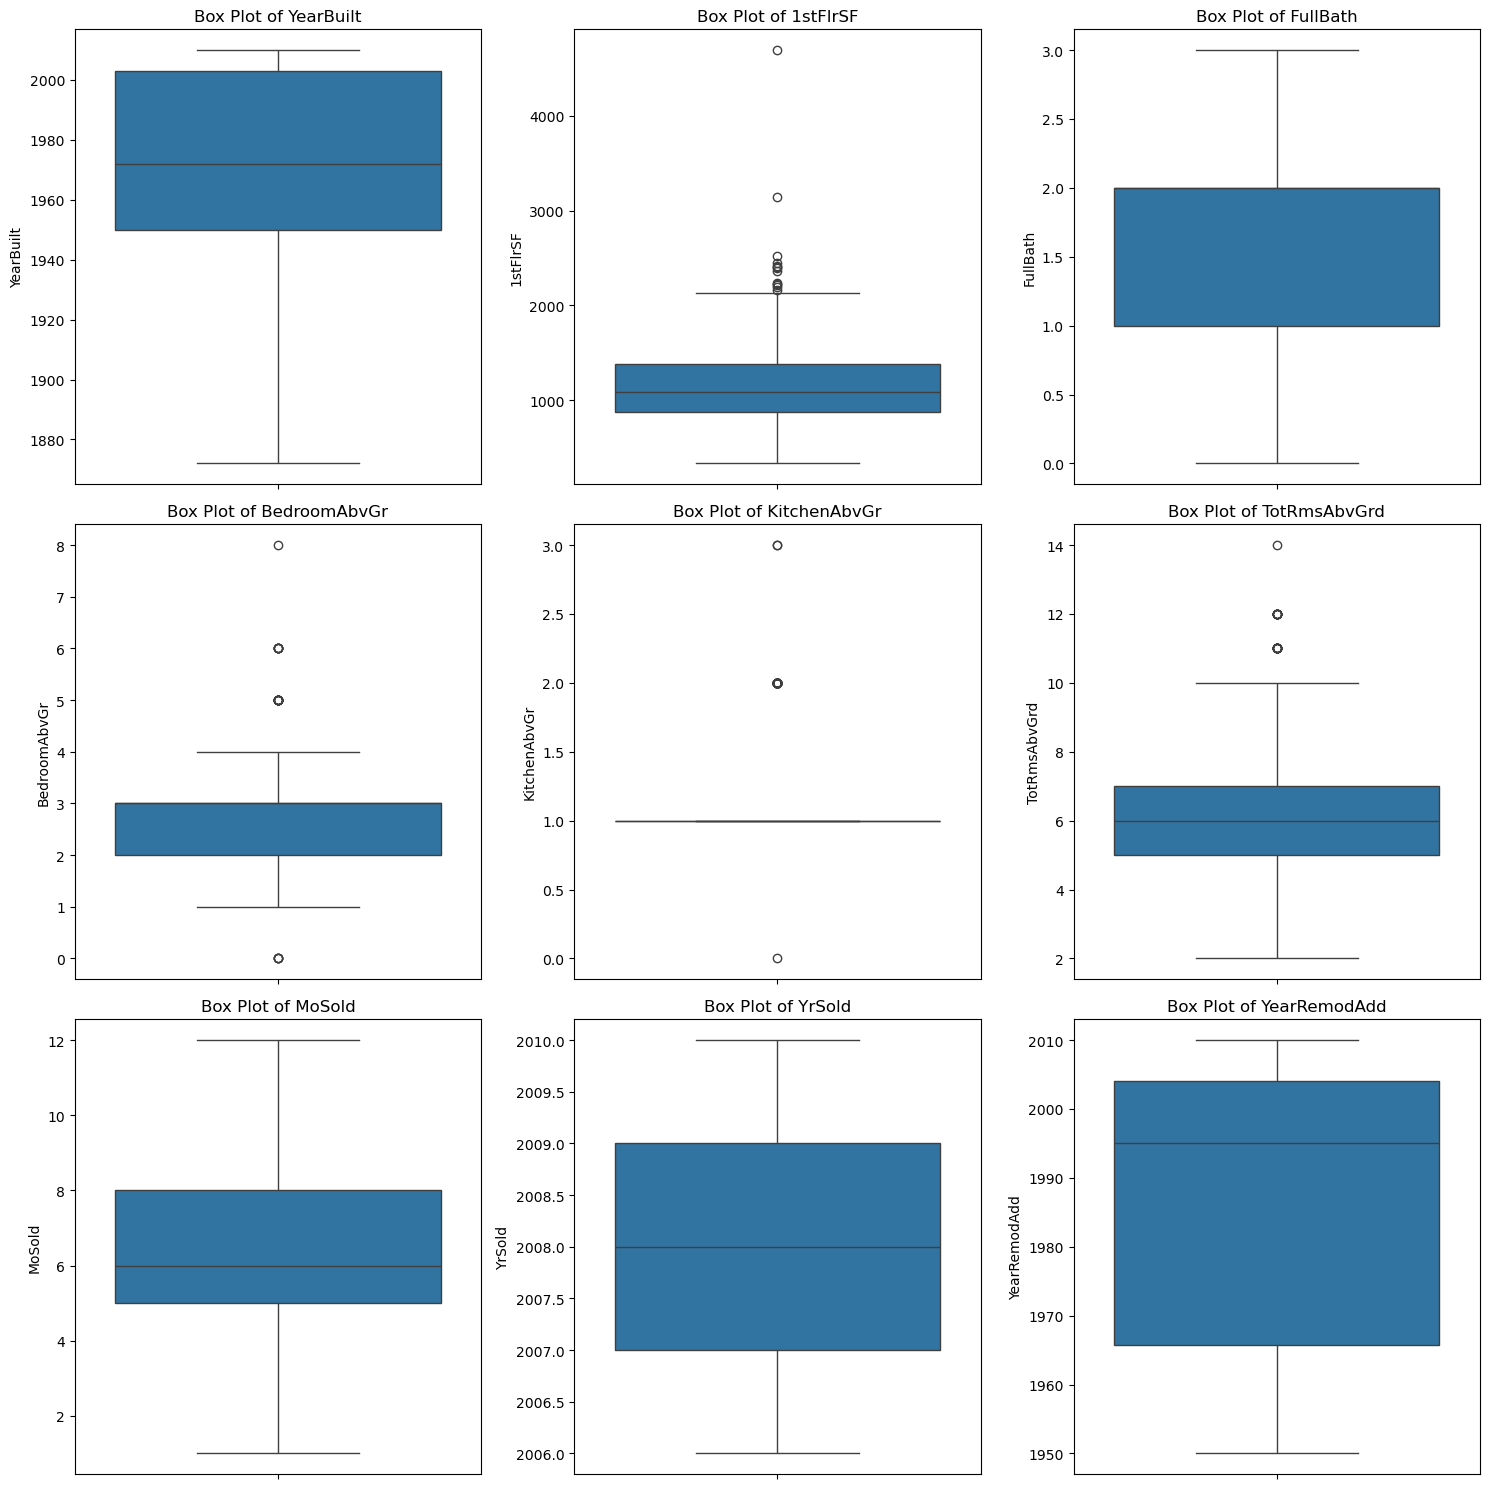


YearBuilt:
Q1: 1950.00
Q3: 2003.00
IQR: 53.00

1stFlrSF:
Q1: 876.00
Q3: 1384.50
IQR: 508.50

FullBath:
Q1: 1.00
Q3: 2.00
IQR: 1.00

BedroomAbvGr:
Q1: 2.00
Q3: 3.00
IQR: 1.00

KitchenAbvGr:
Q1: 1.00
Q3: 1.00
IQR: 0.00

TotRmsAbvGrd:
Q1: 5.00
Q3: 7.00
IQR: 2.00

MoSold:
Q1: 5.00
Q3: 8.00
IQR: 3.00

YrSold:
Q1: 2007.00
Q3: 2009.00
IQR: 2.00

YearRemodAdd:
Q1: 1965.75
Q3: 2004.00
IQR: 38.25


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create box plots for random_var_outlier_num_cols
num_cols = len(random_var_outlier_num_cols)
num_rows = (num_cols + 2) // 3  # 3 plots per row
plt.figure(figsize=(15, 5*num_rows))

for idx, col in enumerate(random_var_outlier_num_cols, 1):
    plt.subplot(num_rows, 3, idx)
    sns.boxplot(y=df_train[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Print IQR values
for col in random_var_outlier_num_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    print(f"\n{col}:")
    print(f"Q1: {Q1:.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")

In [8]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        # Calculate Q1, Q3, and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Create mask for non-outliers
        mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
        df_clean = df_clean[mask]
        
        print(f"{col}: removed {len(df) - len(df_clean)} outliers")
    
    return df_clean

# Remove outliers
df_train_no_outliers = remove_outliers_iqr(df_train, random_var_outlier_num_cols)

# Print shape comparison
print("\nShape comparison:")
print(f"Original: {df_train.shape}")
print(f"After outlier removal: {df_train_no_outliers.shape}")

YearBuilt: removed 0 outliers
1stFlrSF: removed 13 outliers
FullBath: removed 13 outliers
BedroomAbvGr: removed 40 outliers
KitchenAbvGr: removed 91 outliers
TotRmsAbvGrd: removed 103 outliers
MoSold: removed 103 outliers
YrSold: removed 103 outliers

Shape comparison:
Original: (1200, 80)
After outlier removal: (1097, 80)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot LotFrontage boxplot
sns.boxplot(data=df_train['LotFrontage'], ax=ax1, color='skyblue')
ax1.set_title('Box Plot of LotFrontage')
ax1.set_ylabel('LotFrontage')

# Plot LotArea boxplot
sns.boxplot(data=df_train['LotArea'], ax=ax2, color='lightgreen')
ax2.set_title('Box Plot of LotArea')
ax2.set_ylabel('LotArea')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Filter houses with LotFrontage > 300
high_frontage_index = df_train[df_train['LotFrontage'] > 300].index
high_area_index = df_train[df_train['LotArea'] > 70000].index

# Remove 
df_train = df_train.drop(index=high_frontage_index)
df_train = df_train.drop(index=high_area_index)

df_train.shape



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot LotFrontage vs SalePrice
sns.scatterplot(data=df_train, x='LotFrontage', y='SalePrice', ax=ax1, alpha=0.5)
ax1.set_title('LotFrontage vs SalePrice')
ax1.set_xlabel('LotFrontage')
ax1.set_ylabel('SalePrice')

# Plot LotArea vs SalePrice
sns.scatterplot(data=df_train, x='LotArea', y='SalePrice', ax=ax2, alpha=0.5)
ax2.set_title('LotArea vs SalePrice')
ax2.set_xlabel('LotArea')
ax2.set_ylabel('SalePrice')

plt.tight_layout()
plt.show()

In [ ]:
#this is very confusing but im too lazy to change all the df_train names :'))
df_train = df_train_no_outliers

df_train.shape

### Remove outliers for columns where 0 can mean non existant

In [9]:
# Get numeric columns
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

# Get categorical columns
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns

# Remove categorical and random_var_outlier_num_cols from numeric columns
remaining_numeric_cols = [col for col in numeric_cols 
                        if col not in random_var_outlier_num_cols 
                        and col not in cat_cols and col != 'LotFrontage' and col != 'LotArea' and col != 'GrLivArea' and col != 'SalePrice' ]

print("Remaining numeric columns:")
print(remaining_numeric_cols)
print(f"\nNumber of remaining columns: {len(remaining_numeric_cols)}")

Remaining numeric columns:
['MSSubClass', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

Number of remaining columns: 25


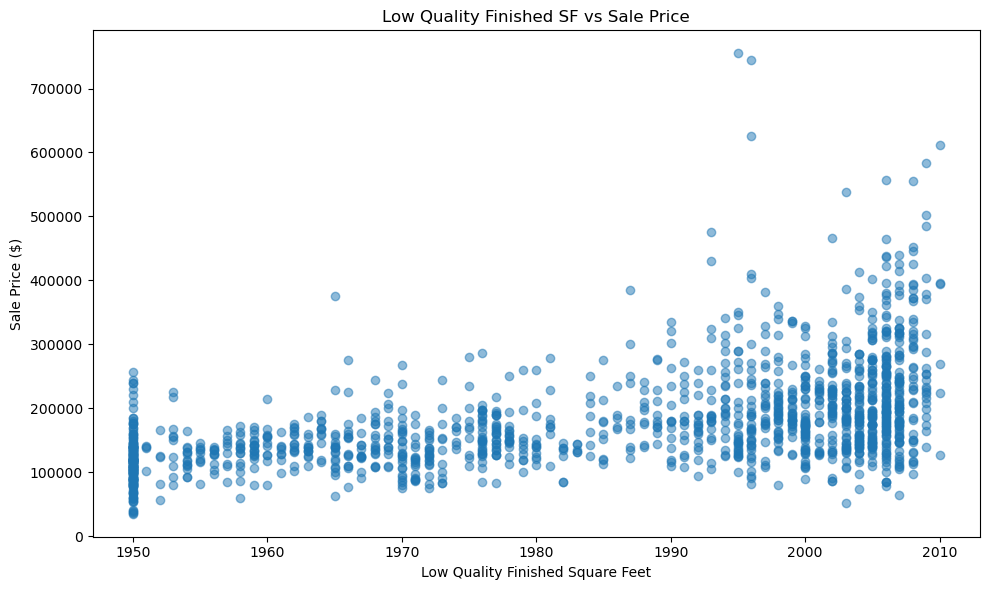

In [24]:

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_train['YearRemodAdd'], df_train['SalePrice'], alpha=0.5)

# Add labels and title
plt.xlabel('Low Quality Finished Square Feet')
plt.ylabel('Sale Price ($)')
plt.title('Low Quality Finished SF vs Sale Price')

# Display plot
plt.tight_layout()
plt.show()

### Columns with no outliers

In [10]:
fixed_num_cols = [
    'MSSubClass', 'OverallQual', 'OverallCond'
]

In [11]:
# Count values in fixed_num_cols to make sure there are no weird values
for col in fixed_num_cols:    
    print(f"Value counts for {col}:")
    print(df_train[col].value_counts())
    print("\n")




Value counts for MSSubClass:
MSSubClass
20     437
60     230
50     128
120     67
30      63
70      55
160     55
90      47
80      37
190     27
75      15
85      14
45      12
180     10
40       3
Name: count, dtype: int64


Value counts for OverallQual:
OverallQual
5     332
6     282
7     266
8     142
4      98
9      42
10     17
3      17
2       3
1       1
Name: count, dtype: int64


Value counts for OverallCond:
OverallCond
5    683
6    206
7    165
8     60
4     46
3     20
9     15
2      5
Name: count, dtype: int64




### Columns that could have outliers

In [12]:
remaining_numeric_cols = [col for col in remaining_numeric_cols if col not in fixed_num_cols]




MasVnrArea:
Q1: 115.25
Q3: 336.25
IQR: 221.00

BsmtFinSF1:
Q1: 360.50
Q3: 862.50
IQR: 502.00

BsmtFinSF2:
Q1: 176.00
Q3: 546.50
IQR: 370.50

BsmtUnfSF:
Q1: 300.00
Q3: 867.00
IQR: 567.00

TotalBsmtSF:
Q1: 804.00
Q3: 1316.00
IQR: 512.00

2ndFlrSF:
Q1: 600.00
Q3: 925.00
IQR: 325.00

LowQualFinSF:
Q1: 192.75
Q3: 474.50
IQR: 281.75

BsmtFullBath:
Q1: 1.00
Q3: 1.00
IQR: 0.00

BsmtHalfBath:
Q1: 1.00
Q3: 1.00
IQR: 0.00

HalfBath:
Q1: 1.00
Q3: 1.00
IQR: 0.00

Fireplaces:
Q1: 1.00
Q3: 1.00
IQR: 0.00

GarageYrBlt:
Q1: 1960.00
Q3: 2003.00
IQR: 43.00

GarageCars:
Q1: 1.00
Q3: 2.00
IQR: 1.00

GarageArea:
Q1: 360.00
Q3: 600.00
IQR: 240.00

WoodDeckSF:
Q1: 120.00
Q3: 237.00
IQR: 117.00

OpenPorchSF:
Q1: 38.00
Q3: 110.00
IQR: 72.00

EnclosedPorch:
Q1: 103.50
Q3: 200.00
IQR: 96.50

3SsnPorch:
Q1: 146.25
Q3: 237.75
IQR: 91.50

ScreenPorch:
Q1: 142.50
Q3: 224.00
IQR: 81.50

PoolArea:
Q1: 513.75
Q3: 570.75
IQR: 57.00

MiscVal:
Q1: 400.00
Q3: 800.00
IQR: 400.00


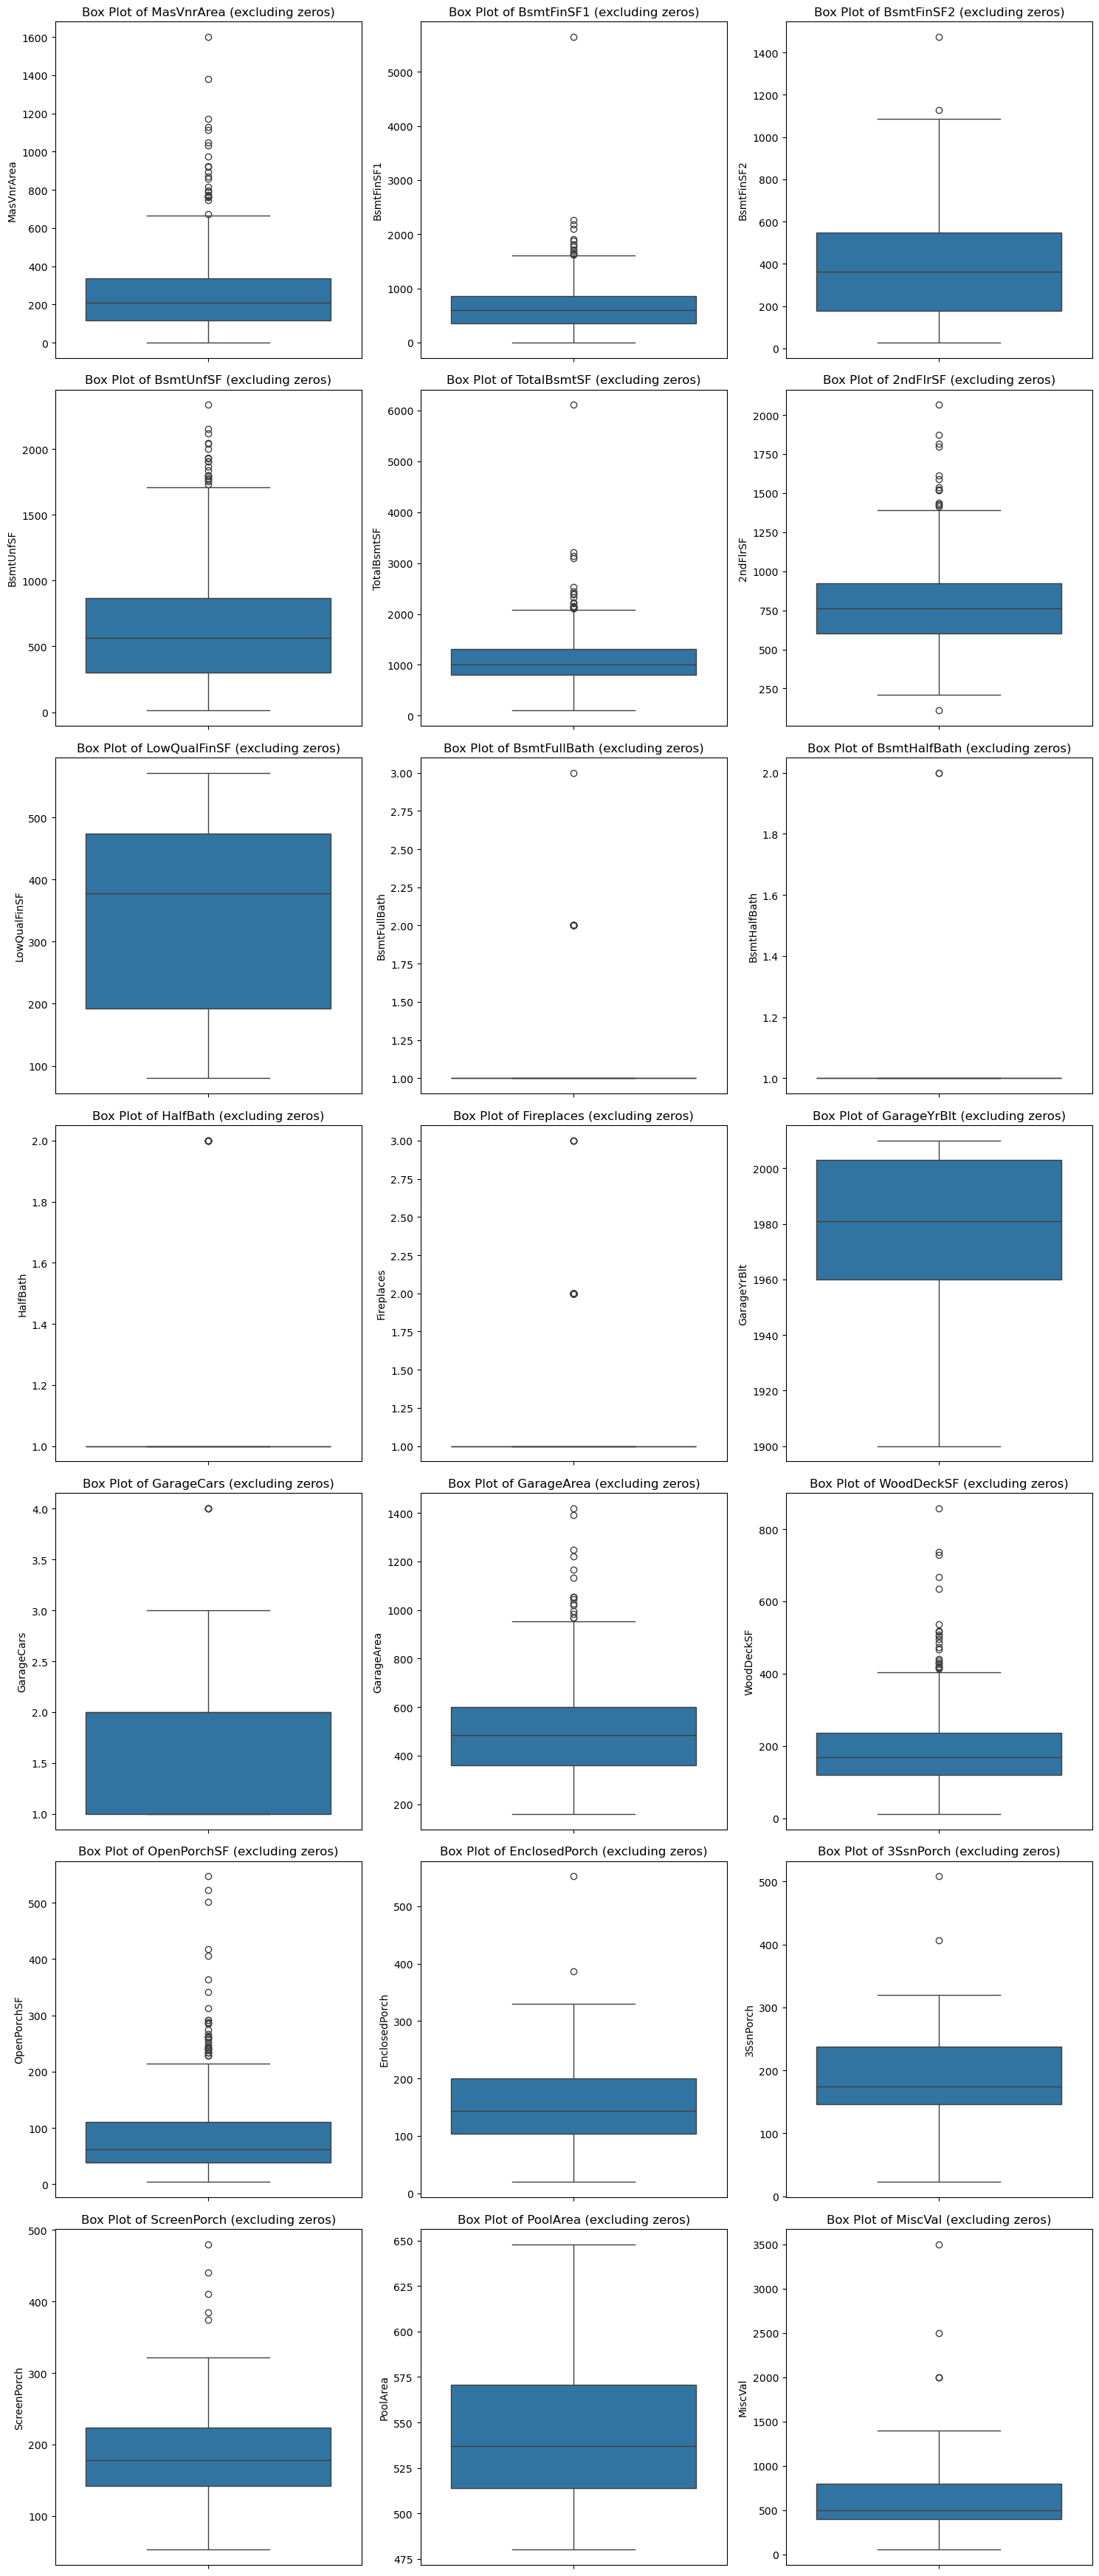

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate IQR excluding zeros
for col in remaining_numeric_cols:
    # Filter out zeros
    filtered_data = df_train[df_train[col] != 0][col]
    
    # Calculate IQR if data exists
    if not filtered_data.empty:
        Q1 = filtered_data.quantile(0.25)
        Q3 = filtered_data.quantile(0.75)
        IQR = Q3 - Q1
        print(f"\n{col}:")
        print(f"Q1: {Q1:.2f}")
        print(f"Q3: {Q3:.2f}")
        print(f"IQR: {IQR:.2f}")

# Create box plots excluding zeros
num_cols = len(remaining_numeric_cols)
num_rows = (num_cols + 2) // 3
plt.figure(figsize=(15, 5*num_rows))

for idx, col in enumerate(remaining_numeric_cols, 1):
    plt.subplot(num_rows, 3, idx)
    # Filter zeros before plotting
    filtered_data = df_train[df_train[col] != 0][col]
    sns.boxplot(y=filtered_data)
    plt.title(f'Box Plot of {col} (excluding zeros)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [13]:
def calculate_modified_zscore(series):
    filtered = series[series != 0]
    if len(filtered) == 0:
        return pd.Series(np.zeros(len(series)), index=series.index)
    
    median = np.median(filtered)
    mad = np.median(np.abs(filtered - median))
    modified_zscore = 0.6745 * (series - median) / mad if mad != 0 else 0
    return modified_zscore

# Create copy for cleaning
df_clean = df_train.copy()

for col in remaining_numeric_cols:
    # Calculate Modified Z-score on filtered data
    filtered_data = df_clean[df_clean[col] != 0][col]
    df_clean[f'{col}_mod_zscore'] = calculate_modified_zscore(filtered_data)
    
    # Identify outliers
    outlier_mask = abs(df_clean[f'{col}_mod_zscore']) > 3.5
    outliers = df_clean[outlier_mask]
    
    # Remove outliers
    df_clean = df_clean[~outlier_mask]
    
    print(f"\n{col}:")
    print(f"Number of outliers removed: {len(outliers)}")
    print(f"Remaining rows: {len(df_clean)}")
    
    # # Plot before/after distribution
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # # Before removal
    # ax1.scatter(range(len(filtered_data)), filtered_data)
    # ax1.set_title(f'{col} Before Outlier Removal')
    
    # # After removal
    # cleaned_data = df_clean[df_clean[col] != 0][col]
    # ax2.scatter(range(len(cleaned_data)), cleaned_data)
    # ax2.set_title(f'{col} After Outlier Removal')
    
    # plt.tight_layout()
    # plt.show()


YearRemodAdd:
Number of outliers removed: 0
Remaining rows: 1200

MasVnrArea:
Number of outliers removed: 0
Remaining rows: 1200

BsmtFinSF1:
Number of outliers removed: 6
Remaining rows: 1194

BsmtFinSF2:
Number of outliers removed: 1
Remaining rows: 1193

BsmtUnfSF:
Number of outliers removed: 5
Remaining rows: 1188

TotalBsmtSF:
Number of outliers removed: 5
Remaining rows: 1183

2ndFlrSF:
Number of outliers removed: 3
Remaining rows: 1180

LowQualFinSF:
Number of outliers removed: 0
Remaining rows: 1180

BsmtFullBath:
Number of outliers removed: 0
Remaining rows: 1180

BsmtHalfBath:
Number of outliers removed: 0
Remaining rows: 1180

HalfBath:
Number of outliers removed: 0
Remaining rows: 1180

Fireplaces:
Number of outliers removed: 0
Remaining rows: 1180

GarageYrBlt:
Number of outliers removed: 0
Remaining rows: 1180

GarageCars:
Number of outliers removed: 0
Remaining rows: 1180

GarageArea:
Number of outliers removed: 3
Remaining rows: 1177

WoodDeckSF:
Number of outliers rem

In [14]:
df_clean

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageYrBlt_mod_zscore,GarageCars_mod_zscore,GarageArea_mod_zscore,WoodDeckSF_mod_zscore,OpenPorchSF_mod_zscore,EnclosedPorch_mod_zscore,3SsnPorch_mod_zscore,ScreenPorch_mod_zscore,PoolArea_mod_zscore,MiscVal_mod_zscore
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,0.372138,NaN,0.024089,NaN,NaN,NaN,NaN,NaN
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,0,-0.139552,1.638972,NaN,NaN,NaN,NaN,NaN,NaN
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,0,0.721017,NaN,-0.433607,NaN,NaN,NaN,NaN,NaN
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,0,0.918716,NaN,-0.602232,1.798667,NaN,NaN,NaN,NaN
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,0,2.046759,0.302579,0.578143,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,20,RL,90.0,17217,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,NaN,-1.664187,-0.096357,NaN,NaN,NaN,NaN,NaN
1454,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,AllPub,Inside,...,NaN,0,-0.488431,NaN,1.276732,NaN,NaN,NaN,NaN,NaN
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,-0.139552,NaN,-0.481786,NaN,NaN,NaN,NaN,NaN
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,0.093034,2.281953,NaN,NaN,NaN,NaN,NaN,NaN


### Making the actual clean dataframe

In [15]:
# Find common indices
common_indices = df_train_no_outliers.index.intersection(df_clean.index)

# Create new dataframe with common rows
df_final = df_train_no_outliers.loc[common_indices]

# Print shape information
print("Original shapes:")
print(f"df_train_no_outliers: {df_train_no_outliers.shape}")
print(f"df_clean: {df_clean.shape}")
print(f"\nFinal shape after intersection: {df_final.shape}")

Original shapes:
df_train_no_outliers: (1097, 80)
df_clean: (1117, 102)

Final shape after intersection: (1036, 80)


In [16]:
df_train = df_final

## Changing all columns to numerical quantities

In [17]:
#Change columns with 'Yes'/'No' to 1/0
yes_no_cols = [col for col in df_train.columns if set(df_train[col].unique()) == {'Yes', 'No'}]
for col in yes_no_cols:
    df_train[col] = df_train[col].map({'Yes': 1, 'No': 0})

# One-hot encode categorical variables


# Identify categorical and object columns
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Categorical columns to encode: {cat_cols}")
print(f"Number of categorical columns: {len(cat_cols)}")

# Initialize OneHotEncoder
# sparse_output=False returns a dense array instead of sparse matrix
# handle_unknown='ignore' will ignore unknown categories during transform
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None)

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df_train[cat_cols])

# Get feature names for the encoded columns
encoded_feature_names = encoder.get_feature_names_out(cat_cols)

# Create a dataframe with the encoded features
df_encoded = pd.DataFrame(
    encoded_array, 
    columns=encoded_feature_names,
    index=df_train.index
)

# Drop original categorical columns and concatenate encoded columns
df_train_encoded = df_train.drop(columns=cat_cols)
df_train_encoded = pd.concat([df_train_encoded, df_encoded], axis=1)

# Convert boolean columns to integers (if any remain)
bool_cols = df_train_encoded.select_dtypes(include='bool').columns
if len(bool_cols) > 0:
    df_train_encoded[bool_cols] = df_train_encoded[bool_cols].astype(int)

print(f"\nOriginal shape: {df_train.shape}")
print(f"Encoded shape: {df_train_encoded.shape}")
print(f"\nFirst few rows:")
df_train_encoded.head()




Categorical columns to encode: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Number of categorical columns: 43

Original shape: (1036, 80)
Encoded shape: (1036, 287)

First few rows:


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df_train_encoded.info()

In [ ]:


# Initialize scaler
scaler = MinMaxScaler()

# Create copy and drop SalePrice temporarily
X = df_train_encoded.drop('SalePrice', axis=1)
y = df_train_encoded['SalePrice']

# Scale features
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns
)

# Scale SalePrice separately
y_scaled = pd.DataFrame(
    scaler.fit_transform(y.values.reshape(-1, 1)),
    columns=['SalePrice']
)
# First identify columns with zero variance
zero_var_cols = []
valid_cols = []

for col in X_scaled.columns:
    if X_scaled[col].std() == 0:
        zero_var_cols.append(col)
    else:
        valid_cols.append(col)

print("Columns with zero variance (all identical values):")
for col in zero_var_cols:
    print(f"{col}: unique value = {X_scaled[col].iloc[0]}")



# Now calculate regression only for valid columns
results = []
for col in valid_cols:
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        X_scaled[col], 
        y_scaled['SalePrice']
    )
    r_squared = r_value**2
    results.append({
        'Column': col,
        'R-squared': r_squared,
        'p-value': p_value
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R-squared', ascending=False)
# print("\nRegression results for valid columns:")
# print(results_df.to_string(float_format=lambda x: '{:.6f}'.format(x)))

# Filter for significant p-values
significant_linear_results = results_df[results_df['p-value'] <= 0.05].copy()

# Sort by R-squared value
significant_linear_results = significant_linear_results.sort_values('R-squared', ascending=False)

# Display results
print("Columns with significant p-values (p ≤ 0.05):")
print(significant_linear_results.to_string(float_format=lambda x: '{:.6f}'.format(x)))

# Store significant column names
significant_linear_cols = significant_linear_results['Column'].tolist()
print(f"\nNumber of significant features: {len(significant_linear_cols)}")

In [ ]:
# Calculate Spearman's r for each column
results = []
for col in X_scaled.columns:
    # Calculate Spearman correlation
    correlation, p_value = stats.spearmanr(X_scaled[col], y_scaled['SalePrice'])
    results.append({
        'Column': col,
        'Spearman_r': correlation,
        'p-value': p_value
    })

# Convert to dataframe and sort by correlation strength
results_df = pd.DataFrame(results)
results_df['abs_correlation'] = abs(results_df['Spearman_r'])
results_df = results_df.sort_values('abs_correlation', ascending=False)
results_df = results_df.drop('abs_correlation', axis=1)

# # Display results
# pd.set_option('display.max_rows', None)
# print(results_df.to_string(float_format=lambda x: '{:.6f}'.format(x)))

# Filter for significant Spearman correlations
spearman_significant = results_df[results_df['p-value'] <= 0.05].copy()

# Sort by absolute correlation value
spearman_significant['abs_correlation'] = abs(spearman_significant['Spearman_r'])
spearman_significant = spearman_significant.sort_values('abs_correlation', ascending=False)
spearman_significant = spearman_significant.drop('abs_correlation', axis=1)

# # Display results
# print("Features with significant Spearman correlations (p ≤ 0.05):")
# print(spearman_significant.to_string(float_format=lambda x: '{:.6f}'.format(x)))

# Store significant column names
significant_spearman_cols = spearman_significant['Column'].tolist()
print(f"\nNumber of significant features: {len(significant_spearman_cols)}")

# Filter for strong correlations (|r| >= 0.1) from significant results
strong_spearman_corr = spearman_significant[abs(spearman_significant['Spearman_r']) >= 0.1].copy()

# Sort by absolute correlation value
strong_spearman_corr['abs_correlation'] = abs(strong_spearman_corr['Spearman_r'])
strong_spearman_corr = strong_spearman_corr.sort_values('abs_correlation', ascending=False)
strong_spearman_corr = strong_spearman_corr.drop('abs_correlation', axis=1)

# Display results
print("Features with strong Spearman correlations (|r| ≥ 0.1 and p ≤ 0.05):")
print(strong_spearman_corr.to_string(float_format=lambda x: '{:.6f}'.format(x)))

# Store filtered column names
strong_spearman_corr_cols = strong_spearman_corr['Column'].tolist()
print(f"\nNumber of strong correlation features: {len(strong_spearman_corr_cols)}")

### Choose only significant columns from both analyses

In [ ]:
df_train_pearson = df_train_encoded[significant_linear_cols + ['SalePrice']]
df_train_pearson.info()

In [ ]:
df_train_spearman = df_train_encoded[strong_spearman_corr_cols + ['SalePrice']]
df_train_spearman.info()

## ยังไม่ได้ทำำำำำ Applying the same method to the test data.

In [ ]:
data_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(data_test)

df_test

# Training Numeric Models :0

## XGBoost

### On significant_pearson

In [64]:
# setting up the data and target variables
data = df_train_pearson.drop('SalePrice', axis=1)
target = df_train_pearson['SalePrice']

# Splitting the training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

### On significant_spearman

In [58]:
# setting up the data and target variables
data = df_train_spearman.drop('SalePrice', axis=1)
target = df_train_spearman['SalePrice']

# Splitting the training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

In [ ]:
X_train.info()

In [ ]:
# initialize the model
model = xgb.XGBRegressor(objective='reg:squaredlogerror')  
# fit the model
model.fit(X_train, y_train)
# make predictions
y_pred = model.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

### On all encoded data

In [18]:
# setting up the data and target variables
data = df_train_encoded.drop('SalePrice', axis=1)
target = df_train_encoded['SalePrice']

# Splitting the training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

In [ ]:
X_train.info()

In [19]:
# initialize the model
model = xgb.XGBRegressor(objective='reg:squarederror')  
# fit the model
model.fit(X_train, y_train)
# make predictions
y_pred = model.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 672564608.00
Root Mean Squared Error: 25933.85
Mean Absolute Error: 16685.55
R² Score: 0.88


## Doing Numeric models

### Dummy Regressor

In [ ]:
dum = dummy.DummyRegressor()
dum.fit(X_train, y_train)
y_pred = dum.predict(X_test)
y_pred


In [ ]:
# Store the actual data and the predictions in a DataFrame for later
price_test = pd.DataFrame()
price_test["Actual_price"] = y_test
price_test["Dummy_price"] = y_pred

price_test

In [ ]:
# Baseline: Dummy Regressor
print("\n" + "="*50)
print("DUMMY REGRESSOR (Baseline)")
print("="*50)
dum = dummy.DummyRegressor()
dum.fit(X_train, y_train)
y_pred_dummy = dum.predict(X_test)

dummy_mse = metrics.mean_squared_error(y_test, y_pred_dummy)
dummy_rmse = np.sqrt(dummy_mse)
dummy_r2 = metrics.r2_score(y_test, y_pred_dummy)

print(f"Dummy MSE:  {dummy_mse:,.2f}")
print(f"Dummy RMSE: {dummy_rmse:,.2f}")
print(f"Dummy R²:   {dummy_r2:.4f}")

### Linear Regression with all attributes

In [20]:
# HistGradientBoostingRegressor (handles NaN natively)
print("\n" + "="*50)
print("HIST GRADIENT BOOSTING REGRESSOR")
print("="*50)

hgb = HistGradientBoostingRegressor(
    max_iter=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)

hgb_mse = metrics.mean_squared_error(y_test, y_pred_hgb)
hgb_rmse = np.sqrt(hgb_mse)
hgb_r2 = metrics.r2_score(y_test, y_pred_hgb)
hgb_mae = metrics.mean_absolute_error(y_test, y_pred_hgb)

print(f"HGB MSE:  {hgb_mse:,.2f}")
print(f"HGB RMSE: {hgb_rmse:,.2f}")
print(f"HGB MAE:  {hgb_mae:,.2f}")
print(f"HGB R²:   {hgb_r2:.4f}")

# Compare models
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Improvement over baseline (RMSE): {((dummy_rmse - hgb_rmse) / dummy_rmse * 100):.2f}%")
print(f"Improvement over baseline (R²):   {((hgb_r2 - dummy_r2) / abs(dummy_r2) * 100):.2f}%")

# Feature importance (top 10)
print("\n" + "="*50)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*50)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': hgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


HIST GRADIENT BOOSTING REGRESSOR
HGB MSE:  428,445,735.84
HGB RMSE: 20,698.93
HGB MAE:  13,719.71
HGB R²:   0.9225

MODEL COMPARISON


NameError: name 'dummy_rmse' is not defined